## **Image embedding extraction via transfer learning from VGG16**

## 1 Mounting Google Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 2 Loading layers from VGG16

In [26]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model
import numpy as np 


vgg_model = VGG16(weights='imagenet', include_top=False, input_shape = (224,224, 3)) 
block5_pool = vgg_model.get_layer("block5_pool").output
f0 = Flatten()(block5_pool)

transferred_model = Model(inputs=vgg_model.input, outputs=f0)
transferred_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

## 3 Loading 12 basic features and labels of training and testing segments

Purpose:

*   Labels of training data can be used to train the dense layer part in our transferred model to compress the embedding from (25088,) to (1024,)
*   Features can be used to train xgboost model so that we can compare the performance of xgboost model with respect to the involvement of image embedding.



In [0]:
import pandas as pd
import numpy as np
from os.path import join
import glob
import os

# Chelsea's path to basic feature files of training and test segment
training_prefix='/content/drive/My Drive/Waymo_data/transfer_learning_dataset/training'
test_prefix='/content/drive/My Drive/Waymo_data/transfer_learning_dataset/validation'

# Data is loading in the 
def load_data_from_files_with_id(prefix):
    prefix = prefix.rstrip(os.sep)
    files = [f for f in glob.iglob(join(prefix, join('**', '*.csv')), recursive=True)]

    # to ensure features are loaded of which frames maps to the image loaded later on, 
    # so that basic feature and image embedding can be concated horizontally
    files.sort()

    print("Loading data from {} files...".format(len(files)))

    df_list = []
    for i in range(len(files)):
      df = pd.read_csv(files[i], header = 0)
      idx = [i] * df.shape[0]
      df['id'] = idx
      df_list.append(df)
    
    data = pd.concat(df_list)
    return data.set_index('id')

In [28]:
train = load_data_from_files_with_id(training_prefix)
test = load_data_from_files_with_id(test_prefix)

print(train.shape, test.shape)

Loading data from 50 files...
Loading data from 25 files...
(9922, 15) (4964, 15)


In [29]:
train.head()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az
id,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,12.832332,-0.106879,2.686089e-29,5.332602e-29,-9.594011e-31,0.000000e+00,0.000000e+00,0.000000e+00,43.0,0.0,0.0,0.0
0,0.0,0.0,0.0,12.832294,-0.106869,2.350332e-29,4.666030e-29,-8.359340e-31,3.340616e-29,6.632056e-29,-1.228436e-30,43.0,0.0,0.0,0.0
0,0.0,0.0,0.0,12.832428,-0.106985,2.014567e-29,3.999451e-29,-7.195508e-31,3.340694e-29,6.632123e-29,-1.157954e-30,43.0,0.0,0.0,0.0
0,0.0,0.0,0.0,12.832391,-0.106895,1.678811e-29,3.332877e-29,-5.970958e-31,3.340605e-29,6.632079e-29,-1.218365e-30,43.0,0.0,0.0,0.0
0,0.0,0.0,0.0,12.832250,-0.106930,1.343042e-29,2.666298e-29,-4.817243e-31,3.340730e-29,6.632123e-29,-1.147888e-30,43.0,0.0,0.0,0.0


## 4 Loading training and testing images for embedding extraction

In [0]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from os import walk
from os.path import join

training_imgs_prefix = "/content/drive/My Drive/Waymo_data/imgs/training"
test_imgs_prefix = "/content/drive/My Drive/Waymo_data/imgs/validation"

def get_sorted_img_paths(prefix):
  paths = []
  for root, _21, files in walk(prefix, topdown=False):
    for name in files:
      paths.append(join(root, name))

  # Same functionality as that of files.sort() in load_data_from_files_with_id
  paths.sort()

  print("Loading imgs from {} paths".format(len(paths)))

  return paths

def load_imgs(img_paths, dest_path=None):
  data = []
  for i, img_path in enumerate(img_paths):
    img = image.load_img(img_path, target_size=(224,224,3))
    img_data = image.img_to_array(img)
    data.append(np.expand_dims(img_data, axis=0))

    if i % 10 == 0:
      print("Progress: {}/{}".format(i, len(img_paths)))

  data_np = np.vstack(data)

  # Save imgs to npy files for quicker access instead of loading 
  # a large number of images from time to time
  # Next time can call img_np = np.load(dest_path) to load images
  if dest_path:
    print("Saving data to {}...".format(dest_path))
    np.save(dest_path, data_np)

  return data_np

In [0]:
training_embedding_prefix = "/content/drive/My Drive/Waymo_data/img_embedding/training"
test_embedding_prefix = "/content/drive/My Drive/Waymo_data/img_embedding/validation"

training_imgs_np_file = join(training_embedding_prefix, "training_imgs.npy")
test_imgs_np_file = join(test_embedding_prefix, "test_imgs.npy")

training_sparse_embedding_file = join(training_embedding_prefix, "training_sparse_embedding.npy")
test_sparse_embedding_file = join(test_embedding_prefix, "test_sparse_embedding.npy")

training_embedding_path = join(training_embedding_prefix, "training_img_embedding.npy")
test_embedding_path = join(test_embedding_prefix, "test_img_embedding.npy")

In [23]:
sorted_training_img_paths = get_sorted_img_paths(training_imgs_prefix)
training_imgs_np = load_imgs(sorted_training_img_paths, dest_path=training_imgs_np_file)

sorted_test_img_paths = get_sorted_img_paths(test_imgs_prefix)
test_imgs_np_file = load_imgs(sorted_test_img_paths, dest_path=test_imgs_np_file)

Loading imgs from 4964 paths
Progress: 0/4964
Progress: 10/4964
Progress: 20/4964
Progress: 30/4964
Progress: 40/4964
Progress: 50/4964
Progress: 60/4964
Progress: 70/4964
Progress: 80/4964
Progress: 90/4964
Progress: 100/4964
Progress: 110/4964
Progress: 120/4964
Progress: 130/4964
Progress: 140/4964
Progress: 150/4964
Progress: 160/4964
Progress: 170/4964
Progress: 180/4964
Progress: 190/4964
Progress: 200/4964
Progress: 210/4964
Progress: 220/4964
Progress: 230/4964
Progress: 240/4964
Progress: 250/4964
Progress: 260/4964
Progress: 270/4964
Progress: 280/4964
Progress: 290/4964
Progress: 300/4964
Progress: 310/4964
Progress: 320/4964
Progress: 330/4964
Progress: 340/4964
Progress: 350/4964
Progress: 360/4964
Progress: 370/4964
Progress: 380/4964
Progress: 390/4964
Progress: 400/4964
Progress: 410/4964
Progress: 420/4964
Progress: 430/4964
Progress: 440/4964
Progress: 450/4964
Progress: 460/4964
Progress: 470/4964
Progress: 480/4964
Progress: 490/4964
Progress: 500/4964
Progress: 510

In [35]:
# Quicker loading
training_img_np = np.load(training_imgs_np_file)
test_img_np = np.load(test_imgs_np_file)

print(training_img_np.shape, test_img_np.shape)

training_embedding_sparse = transferred_model.predict(training_img_np)
test_embedding_sparse = transferred_model.predict(test_img_np)

print(training_embedding_sparse.shape, test_embedding_sparse.shape)

# np.save(training_sparse_embedding_file, training_embedding_sparse)
# np.save(test_sparse_embedding_file, test_embedding_sparse)

(9922, 224, 224, 3) (4964, 224, 224, 3)
(9922, 25088) (4964, 25088)


## 5 Training dense layer to compress embedding

One model per label (either 'ax' or 'ay')

In [36]:
import pandas as pd
import keras
from keras.layers import Conv1D
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import Flatten
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from keras.models import Sequential
from keras.layers import Dense

embedding_dims = 25088

fc_model = Sequential()
fc_model.add(Dense(4096, input_dim=embedding_dims, activation='relu'))
fc_model.add(Dense(1024, activation='relu'))
fc_model.add(Dense(128, activation='relu'))
fc_model.add(Dense(1, activation='sigmoid'))
epochs = 5
lrate = 0.01
decay = lrate/epochs
fc_model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics = ['mae'])
fc_model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              4195328   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               131200    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 107,091,201
Trainable params: 107,091,201
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Your own training and test sparse embedding paths
X_train = np.load(training_sparse_embedding_file)
X_test = np.load(test_sparse_embedding_file)

y_train = train.loc[:,['ax']]
print(X_train.shape, y_train.shape)

(9922, 25088) (9922, 1)


In [39]:
fc_model.fit(X_train, y_train, epochs=epochs)

Epoch 1/5
9922/9922 [==============================] - 12s 1ms/step - loss: 0.3051 - mean_absolute_error: 0.3051
Epoch 2/5
9922/9922 [==============================] - 10s 981us/step - loss: 0.3050 - mean_absolute_error: 0.3050
Epoch 3/5
9922/9922 [==============================] - 9s 938us/step - loss: 0.3050 - mean_absolute_error: 0.3050
Epoch 4/5
9922/9922 [==============================] - 9s 957us/step - loss: 0.3050 - mean_absolute_error: 0.3050
Epoch 5/5
9922/9922 [==============================] - 9s 950us/step - loss: 0.3050 - mean_absolute_error: 0.3050


## 6 Getting the intermediate output of the dense layer 
to be our final embedding

In [41]:
# Embedding model
# Get the name of intermediate layer from the summary above
embedding_output = fc_model.get_layer("dense_6").output
embedding_model = Model(inputs=fc_model.input, outputs=embedding_output)
embedding_model.summary()

# Image embedding of training images
train_embedding = embedding_model.predict(X_train)
# np.save(training_embedding_path, train_embedding)

# Image embedding of testing images
test_embedding = embedding_model.predict(X_test)
# np.save(test_embedding_path, test_embedding)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5_input (InputLayer)   (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 4096)              102764544 
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              4195328   
Total params: 106,959,872
Trainable params: 106,959,872
Non-trainable params: 0
_________________________________________________________________


## 7 Performance Comparison

In [0]:
import pandas as pd
import numpy as np
import xgboost
from xgboost import plot_importance
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt

## 7.1 Baseline XGBoost with 12 basic feature

In [43]:
X_train_basic = train.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels']] 
X_test_basic = test.loc[:,['vx', 'vy', 'vz', 'dx', 'dy', 'vfx', 'vfy', 'vfz', 'afx', 'afy', 'afz', 'num_v_labels' ]]

Y_train = train.loc[:,['ax']].values.ravel()
Y_test = test.loc[:,['ax']].values.ravel()

X_train, X_val, y_train, y_val = train_test_split(X_train_basic, Y_train)

print("X_train.shape = {}, X_test.shape = {}".format(X_train.shape, X_val.shape))
print("y_train.shape = {}, y_test.shape = {}".format(y_train.shape, y_val.shape))
print(X_test_basic.shape)

X_train.shape = (7441, 12), X_test.shape = (2481, 12)
y_train.shape = (7441,), y_test.shape = (2481,)
(4964, 12)


In [0]:
# GPU
model_XGB_ax_regressor_basic = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=6,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85, 
        tree_method='gpu_hist', gpu_id=0)

In [45]:
model_XGB_ax_regressor_basic.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50, verbose=False)

[08:01:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05, gpu_id=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=0.85, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [46]:
model_name = "baseline"
y_label = "ax"

print("Predicting {} on test data..".format(model_name))
pred_Y = model_XGB_ax_regressor_basic.predict(X_test_basic)
print("MAE of {} for {} is {}".format(model_name, y_label, mean_absolute_error(pred_Y, Y_test)))

Predicting baseline on test data..
MAE of baseline for ax is 0.3364338257303988


In [20]:
test.head()

,vx,vy,vz,dx,dy,vfx,vfy,vfz,afx,afy,afz,num_v_labels,ax,ay,az
id,,,,,,,,,,,,,,,
0,0.004801,2.324351,-0.034073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.000000,0.000000,0.000000
0,0.003472,2.349684,-0.068385,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.013226,-0.252056,0.341398
0,0.007294,2.128267,0.155320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,-0.038033,2.203045,-2.225811
0,0.009740,1.995876,0.272307,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,-0.024334,1.317251,-1.163993
0,0.008505,2.060056,0.083699,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.012294,-0.638573,1.876606


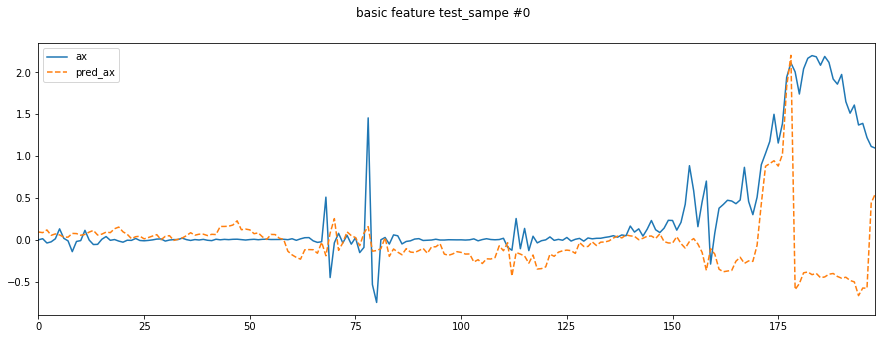

In [47]:
test['pred_ax'] = pred_Y

test_sample_number = 0

test_sample = test.loc[test_sample_number]

test_sample = test_sample.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = test_sample[['ax', 'pred_ax']].plot(ax=ax, style=['-','--'])
plot = plt.suptitle("basic feature test_sampe #{}".format(test_sample_number))

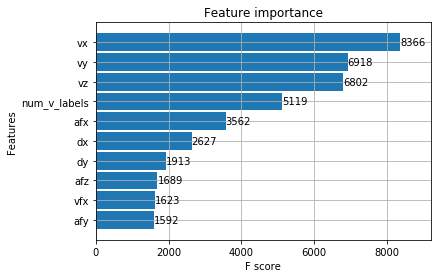

In [48]:
_ = plot_importance(model_XGB_ax_regressor_basic, height=0.9, max_num_features = 10)

## 7.2 12 basic features + image embedding

In [0]:
X_train_embedding = np.load(training_embedding_path)
X_test_embedding = np.load(test_embedding_path)

assert X_train_embedding.shape[0] == X_train_basic.shape[0] == Y_train.shape[0]
assert X_test_embedding.shape[0] == X_test_basic.shape[0] == Y_test.shape[0]

In [52]:
embedding_dims = X_train_embedding.shape[1]

# Adding embedding as part of data frame
eb_cols = ["eb_{}".format(i) for i in range(embedding_dims)]
X_train_img_pd = pd.DataFrame(data=X_train_embedding, columns=eb_cols)
X_test_img_pd = pd.DataFrame(data=X_test_embedding, columns=eb_cols)

print(X_train_img_pd.shape, X_test_img_pd.shape)

(9922, 1024) (4964, 1024)


In [53]:
# Reset index so that can be concated horz successfully
X_train_basic_reidxed = X_train_basic.reset_index(drop=True)
X_test_basic_reidxed = X_test_basic.reset_index(drop=True)

X_train_full = pd.concat([X_train_basic_reidxed, X_train_img_pd], axis=1)
X_test_full = pd.concat([X_test_basic_reidxed, X_test_img_pd], axis=1)

print(X_train_full.shape, X_test_full.shape)

X_train, X_val, y_train, y_val = train_test_split(X_train_full, Y_train)

print("X_train.shape = {}, X_test.shape = {}".format(X_train.shape, X_val.shape))
print("y_train.shape = {}, y_test.shape = {}".format(y_train.shape, y_val.shape))

(9922, 1036) (4964, 1036)
X_train.shape = (7441, 1036), X_test.shape = (2481, 1036)
y_train.shape = (7441,), y_test.shape = (2481,)


In [54]:
# GPU
model_XGB_ax_regressor_full = xgboost.XGBRegressor(
        gamma=0.05,learning_rate=0.05, max_depth=6,
        n_estimators=2500,reg_alpha=0.5, reg_lambda=0.85, 
        tree_method='gpu_hist', gpu_id=0)

model_XGB_ax_regressor_full.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=50, verbose=False)

[08:02:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.05, gpu_id=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=None, n_estimators=2500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0.5, reg_lambda=0.85, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, tree_method='gpu_hist', verbosity=1)

In [55]:
model_name = "baseline"
y_label = "ax"

print("Predicting {} on test data..".format(model_name))
pred_Y_full = model_XGB_ax_regressor_full.predict(X_test_full)
print("MAE of {} for {} is {}".format(model_name, y_label, mean_absolute_error(pred_Y_full, Y_test)))

Predicting baseline on test data..
MAE of baseline for ax is 0.33442392975086466


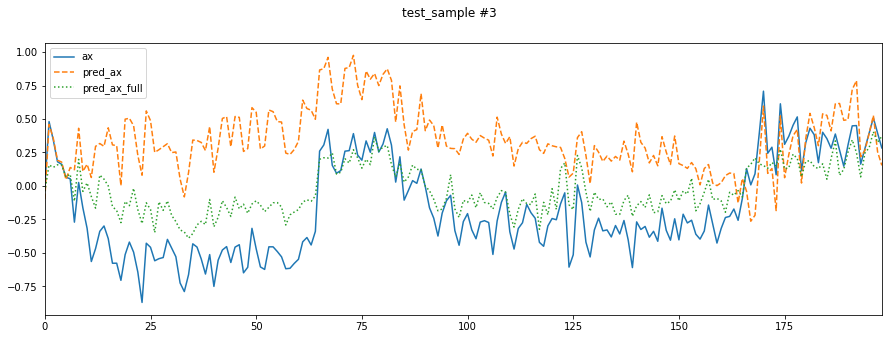

In [56]:
test['pred_ax_full'] = pred_Y_full

test_sample_number = 3

test_sample = test.loc[test_sample_number]

test_sample = test_sample.reset_index()

# Plot the forecast with the actuals
f, ax = plt.subplots(1)

f.set_figheight(5)
f.set_figwidth(15)
_ = test_sample[['ax', 'pred_ax', 'pred_ax_full']].plot(ax=ax, style=['-','--', ':'])
plot = plt.suptitle("test_sample #{}".format(test_sample_number))

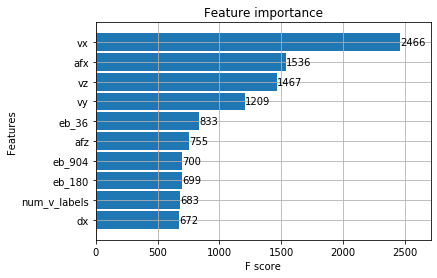

In [57]:
_ = plot_importance(model_XGB_ax_regressor_full, height=0.9, max_num_features = 10)